In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
##### На вебинаре мы использовали товар 999999 - что это за товар?   <br>
Если пользователь не покупает товар из топ 5000, то мы указываем что он покупает данный. Это "все товары вне топ 5000" <br>
##### Зачем он нужен?  <br>
Есть несколько гипотез. <br>
1) Если это не сделать, при подсчете похожести между двумя юзерами у некоторых из них в матрице купленных товаров будут сплошные нули. Значит, в знаменателе мы получим ноль. Конечно, это если я правильно понял формулу :) <br>
2) Мы хотим как-то отличать новых клиентов от тех, кто уже что-то покупал но только из списка вне топ. <br>
3) Мы можем посчитать, как часто система рекомендует товар 999999. Если часто - возможно топ5000 надо расширить? <br>
#### Используя этот товар мы смещаем качество рекомендаций. В какую сторону? Можно ли удалить этот товар? Уберите этот товар и сравните с качеством на семинаре. <br>
В нашем случае мы улучшили качество предсказаний. Следовательно удалить товар можно :) <br>
Но есть сомнения в том, что это правильно: <br>
1) в поле Actual данный товар не фигурирует, значит такое предсказание - заведомо неправильный ответ. Нужна стратегия, как его заменить на что-то конкретное <br>
2) лидеры предсказаний - модели own_purchases и popular_recommendation. Нам выгоднее рекомендовать что-то из топа продаж, чем что-то из-за его пределов. <br> <br>
<b>Далее по коду - загрузка данных из вебинара и расчет метрик</b>

   


In [4]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [5]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [6]:
data_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [7]:
# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\Pavel\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
user_item_matrix.drop(columns=[999999], inplace=True, axis=1)

In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [10]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 803 ms


In [11]:
result1 = data_test.groupby('user_id')['item_id'].unique().reset_index()
result1.columns=['user_id', 'actual']
result1.head(1)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."


In [12]:
result = pd.read_json('predictions_basic.json') # у csv формата куда-то подевались запятые из Actual

In [13]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[118226, 9677175, 1062305, 935408, 6904646]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1946025, 846018, 937872, 6391118, 13768064]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [14]:
%%time

result['itemitem_fictless'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Wall time: 59.9 ms


In [15]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 857 ms


In [16]:
%%time

result['cosine_fictless'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

Wall time: 74.8 ms


In [17]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 874 ms


In [18]:
%%time

result['tfidf_fictless'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=False)])

Wall time: 72.8 ms


In [19]:
result.head(3)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,itemitem_fictless,cosine_fictless,tfidf_fictless
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[118226, 9677175, 1062305, 935408, 6904646]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 961554, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1946025, 846018, 937872, 6391118, 13768064]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 1098066, 981760, 826249, 883404]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[9929199, 8205495, 5981066, 672674, 12263310]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 878996]","[999999, 1082185, 1029743, 6534178, 1127831]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 961554, 1098066]"


In [20]:
result.to_json('predictions_basic_hw.json')

In [21]:
def precision_at_k(recommended_list, bought_list, k=5):
    
#     bought_list = np.array(bought_list)
#     recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    #print(recommended_list)
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    #print(flags)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [22]:
models = result.columns[2:]
score = []
for model_ in models:
    score.append(result.apply(lambda x: precision_at_k(x[model_], x['actual'], k=5), axis=1).mean())    

In [23]:
evaluation = pd.DataFrame({'model': models, 'precision': score})
evaluation.sort_values('precision', ascending=False)

,model,precision
5,own_purchases,0.179693
1,popular_recommendation,0.155240
6,itemitem_fictless,0.152791
8,tfidf_fictless,0.150147
7,cosine_fictless,0.144368
4,tfidf,0.138981
2,itemitem,0.136925
3,cosine,0.132909
0,random_recommendation,0.000588


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма (с вебинара и weighted_random_recommendation) с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество? Почему?

Как было сказано выше, наилучший результат показала модель собственных покупок. Интуитивно - покупатель имеет собственные предпочтениния и следуют им. Математически - покупатель больше всего похож сам на себя, а не на других покупателей. <br>
На втором месте популярные рекомендации. Это просто усредненным топ по всем клиентам <br>
С небольшим отставанием - item-item без фиктивного товара 999999. Плюс данного подхода - рекомендации действительно персонифицированные, перечень рекомендованных товаров шире, чем просто популярные.

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. вес = log(sales_sum товара)
- Придумайте пример 3 весов, посчитайте weighted_random_recommendation для разных весов

In [24]:
# выше мы добавляли 999999, перезапишем датасет на чистый
data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [25]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    recs = np.random.choice(items_weights['item_id'], size=n, p=items_weights['weight'], replace=False)
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

In [26]:
weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
weights['sales_value'] = weights['sales_value'] + 1 # чтобы отсчет был от 1 и выше, из-за логарифма
weights['weight'] = weights['sales_value'].apply(np.log)
weights['weight'] = weights['weight'] / weights['weight'].sum()

In [27]:
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(weights[['item_id','weight']], n=5))

In [28]:
result['weighted_random_recommendation'].head(2)

0    [9802980, 1129207, 1104647, 16122557, 1876470]
1       [961872, 5564181, 1104702, 9420038, 219940]
Name: weighted_random_recommendation, dtype: object

### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
- Попробуйте стратегии ансамблирования изученных алгоритмов


In [29]:
result_tastk3 = result[['user_id', 'actual']]
result_tastk3.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [30]:

for i in range(2, 16):
    model = ItemItemRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                            user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                            N=5, # кол-во рекомендаций 
                            filter_already_liked_items=False, 
                            filter_items=None, 
                            recalculate_user=True)
    


    result_tastk3['itemitem_k'+str(i)] = result_tastk3['user_id'].\
        apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                        model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=None, 
                                        recalculate_user=True)])
    

C:\Users\Pavel\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
result_tastk3.head(2)

,user_id,actual,itemitem_k2,itemitem_k3,itemitem_k4,itemitem_k5,itemitem_k6,itemitem_k7,itemitem_k8,itemitem_k9,itemitem_k10,itemitem_k11,itemitem_k12,itemitem_k13,itemitem_k14,itemitem_k15
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 995242, 840361, 904360, 995785]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 995242, 1098066, 1127831]","[1082185, 981760, 995242, 1127831, 1098066]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1098066]","[1082185, 981760, 995242, 840361, 1098066]","[1082185, 981760, 995242, 840361, 1098066]","[1082185, 981760, 995242, 840361, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 826249, 904360, 883404, 866211]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]"


In [32]:
models = result_tastk3.columns[2:]
score = []
for model_ in models:
    score.append(result_tastk3.apply(lambda x: precision_at_k(x[model_], x['actual'], k=5), axis=1).mean())    

Text(0, 0.5, 'score')

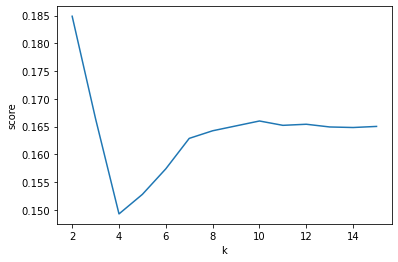

In [34]:
plt.plot([i for i in range(2,16)], score)
plt.xlabel('k')
plt.ylabel('score')

Зафиксируем в качестве оптимального количества соседей значение 10

Попробуем улучшить данный вариант следующий образом: для клиентов, у который мало покупок будем выдавать самые популярные товары. Для остальных - по itemitem

In [137]:
result_improved['actual'].map(len).describe()
# в среднем 38  товаров на человека

count    2042.000000
mean       51.271792
std        47.987761
min         1.000000
25%        15.000000
50%        38.000000
75%        72.000000
max       336.000000
Name: actual, dtype: float64

In [148]:
result_improved = result_tastk3[['user_id', 'actual']]
result_improved.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [149]:
def popularity_recommendation(data, n=15):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

popular_recs = popularity_recommendation(data_train, n=15)

In [150]:
# это можно как-то оформить красиво ? )
for i in range(1, 72):
    
    result_improved['newcomers len <' + str(i)] = result_tastk3['itemitem_k10']
    
    result_improved['newcomers len <' + str(i)].loc[result_improved['actual'].map(len) < i ] =\
    result_improved['newcomers len <' + str(i)].loc[result_improved['actual'].map(len) < i ].apply(lambda x: popular_recs)

In [151]:
models = result_improved.columns[2:]
score_improved = []
for model_ in models:
    score_improved.append(result_improved.apply(lambda x: precision_at_k(x[model_], x['actual'], k=5), axis=1).mean())    

Text(0, 0.5, 'score')

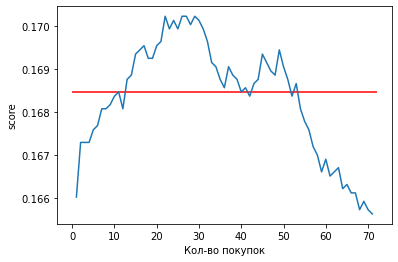

In [152]:
plt.plot([i for i in range(1,72)], score_improved)
plt.hlines(score_improved[10], 0, 72, color='red') # наш результат без добавления лучший рек. для новый клиентов
plt.xlabel('Кол-во покупок')
plt.ylabel('score')

Я интерпретирую это график в следующем ключе: я вижу явную горку от 21 до 30, значит нам выгодно рекомендовать новым клиентам (~25 разных товаров) самое популярное. При этом клиенты, которые уже достаточно ознакомлены с нашим ассортиментом должны получать более персонифицированные рекомендации.

### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Очень интересное задание, но придется его пропустить, чтобы догнать потом и сдавать домашки вовремя. <br>
Было бы очень круто иметь подробный разбор решения подобных заданий, например, в конце урока, или просто отдельным ноутбуком, если кто-то из студентов не против поделиться.<br>
Под подробным разбором я имею ввиду объяснение на пальцах, как это делают некоторые "индусы" на ютубе ))

Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.